In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from scipy.spatial import distance
import main

Generate distribution of ellipses

In [2]:
## generate distribution
grid = [100, 100]
width, height = grid
m = 2       # number of starting points
N = 128     # number of all points

## Selects two random points on a grid
initial = np.array([ [random.uniform(0,1)*width, random.uniform(0,1)*height] for i in range(m) ])
## and generate distribution with Mitchell algorithm
dist = main.distribution(initial, grid, N)

In [3]:
## change circles into ellipses
a, eps = 1, math.sqrt(21)/5     # big semi-axis and eccentricity
b = a*math.sqrt(1-eps**2)       # small semi-axis
a_width, b_height = 2*a, 2*b    # small and big semi-axis for patches

new_dist = main.ellipses(dist, a, b)

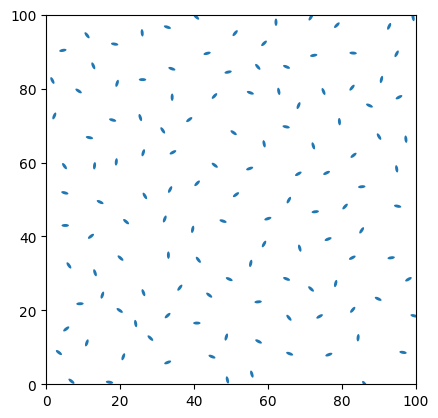

In [4]:
## generate ellipses
plt.axes()

for center in new_dist.ell:
    ellipse = main.ellipse.convert_to_patches(center, a_width, b_height)
    plt.gca().add_patch(ellipse)

plt.axis('scaled')
plt.xlim(0.0, width)
plt.ylim(0.0, height)
# plt.savefig("elipse_512.png")
plt.show()

_____

Enlarge and rotate the ellipses

In [5]:
## start with small ellipses
a, eps = 4.5, math.sqrt(21)/5   # big semi-axis and eccentricity
b = a*math.sqrt(1-eps**2)       # small semi-axis
a_width, b_height = 2*a, 2*b    # small and big semi-axis for patches

new_dist.a = a
new_dist.b = b

## distance matrix between all the centres
S = [x.center for x in new_dist.ell]
distance_matrix = distance.cdist(S, S, dist.periodic_metric)

## matrix of neighbouring ellipses, which are less than 2*a apart
in_proximity = [np.where((line<=2*a) & (line!=0)) for line in distance_matrix]

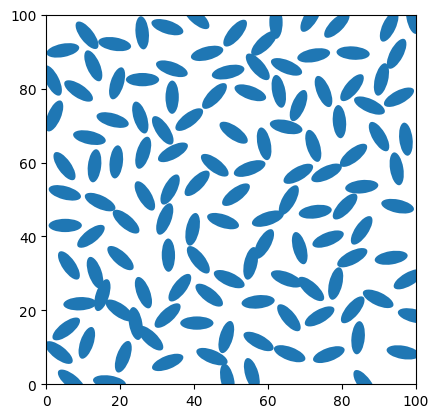

In [6]:
## generate ellipses
plt.axes()

for center in new_dist.ell:
    ellipse = main.ellipse.convert_to_patches(center, a_width, b_height)
    plt.gca().add_patch(ellipse)

plt.axis('scaled')
plt.xlim(0.0, width)
plt.ylim(0.0, height)
# plt.savefig("elipse_512.png")
plt.show()

In [7]:
## do the magic
Energy, accepted, rejected = new_dist.metropolis(in_proximity, n=1000)

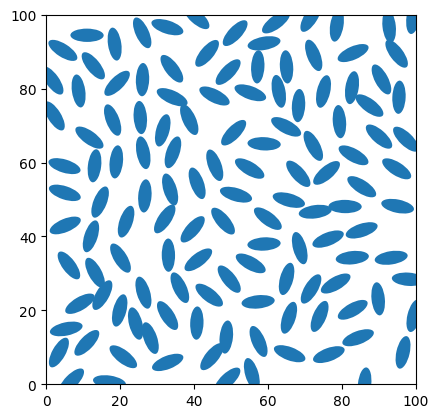

In [8]:
## generate ellipses
plt.axes()

for center in new_dist.ell:
    ellipse = main.ellipse.convert_to_patches(center, a_width, b_height)
    plt.gca().add_patch(ellipse)

plt.axis('scaled')
plt.xlim(0.0, width)
plt.ylim(0.0, height)
# plt.savefig("elipse_512.png")
plt.show()

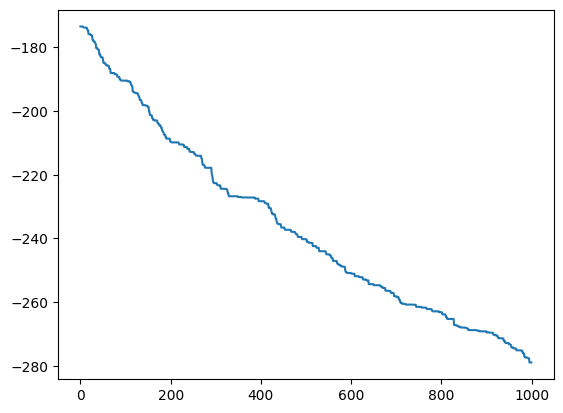

In [9]:
## check parametres
x = np.arange(len(Energy[:,0]))
y = np.sum(Energy, axis=1)
plt.plot(x, y)
plt.show()